Tester avec la derivé !!!!!!!!!!!!

In [1]:
import bayesianchangepoint as bcp
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
from scipy import stats
import glob
import pickle
import os
%matplotlib inline
fig_width = 15

In [2]:
liste = []
for fname in glob.glob('data/*pkl'):
    a = fname.split('/')[1].split('.')[0].split('_')
    liste.append(a)

exp = []
for x in range(len(liste)) :
    if liste[x][0]=='pari' and liste[x][1] in ['AM','BMC','CS','DC','FM','IP','LB','OP','RS','SR','TN','YK']:
        a = 'data/%s_%s_%s_%s.pkl'%(liste[x][0], liste[x][1],liste[x][2],liste[x][3])
        with open(a, 'rb') as fichier :
            b = pickle.load(fichier, encoding='latin1')
            exp.append(b)

param = []
for x in range(len(liste)) :
    if liste[x][0]=='pari' and liste[x][1] in ['AM','BMC','CS','DC','FM','IP','LB','OP','RS','SR','TN','YK']:
        a = 'parametre/param_Fit_%s.pkl'%(liste[x][1])
        with open(a, 'rb') as fichier :
            b = pickle.load(fichier, encoding='latin1')
            param.append(b)

tau max 500?

In [3]:
tau_max = 200
TAU = np.arange(0,tau_max,1)

fig_width=10
t_titre=25
t_label=20

liste_p_hat_e_tau = pickle.load(open('liste_p_hat_e_tau.pkl', 'rb' ))
liste_p_hat_m_tau = pickle.load(open('liste_p_hat_m_tau.pkl', 'rb' ))

In [4]:
def regress(p, b) :
    p=np.asarray(p)
    b=np.asarray(b)
    slope, intercept, r_, p_value, std_err = stats.linregress(p[~np.isnan(b)], b[~np.isnan(b)])
    return r_

In [5]:
def l_regress(ax, x, y, c, position, p_y=tau_max, donne=None) :
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    x_test = np.linspace(np.min(x), np.max(x), 100)
    fitLine = slope * x_test + intercept
    ax.plot(x_test, fitLine, c=c, linewidth=2)
    ax.text(p_y-(p_y/4)-(position*p_y/4),p_y-(p_y/4), 'r = %0.3f'%(r_value), color=c, fontsize=10)
    ax.text(p_y-(p_y/4)-(position*p_y/4),p_y-(p_y/4)-50, 'p_value = %0.3f'%(p_value), color=c, fontsize=10)
    
    if donne is not None :
        return r_value, p_value

In [6]:
def derv(r_results, r_va, seuil=0.00049, dx=1):
    d_r = [(r_results[i+1] - r_results[i])/dx for i in range(len(r_results)-1)]
    d_v = [(r_va[i+1] - r_va[i])/dx for i in range(len(r_va)-1)]

    a=None
    for index, value in enumerate(d_r):
        if value < seuil and a is None :
            i_r = index
            a = 'prout'
    a=None
    for index, value in enumerate(d_v):
        if value < seuil and a is None :
            i_v = index
            a = 'prout'
    return d_r, d_v, i_r, i_v

In [7]:
liste_tau_sujet, liste_r_sujet = {}, {}
liste_tau_block, liste_r_block = {}, {}
liste_tau_pause, liste_r_pause = {}, {}
liste_tau_dr_sujet, liste_r_dr_sujet = {}, {}
liste_tau_dr_block, liste_r_dr_block = {}, {}
liste_tau_dr_pause, liste_r_dr_pause = {}, {}



liste_p_hat_tau = liste_p_hat_e_tau.copy()

for x in range(len(exp)) :
    s = exp[x]['observer'] # sujet
    liste_tau_sujet[s], liste_r_sujet[s] = {}, {}
    liste_tau_block[s], liste_r_block[s] = {}, {}
    liste_tau_pause[s], liste_r_pause[s] = {}, {}
    liste_tau_dr_sujet[s], liste_r_dr_sujet[s] = {}, {}
    liste_tau_dr_block[s], liste_r_dr_block[s] = {}, {}
    liste_tau_dr_pause[s], liste_r_dr_pause[s] = {}, {}
    
    s = exp[x]['observer'] # sujet    
    N_blocks = exp[x]['N_blocks']
    N_trials = exp[x]['N_trials']
    results = (exp[x]['results']+1)/2 # results est sur [-1,1] on le ramene sur [0,1]
    v_anti = param[x]['v_anti']
    
    r_results, r_va = [], []
    for t in range(tau_max) :
        tau = TAU[t]
        phat = []
        res, va = [], []
        for block in range(N_blocks) :
            phat.extend(liste_p_hat_tau['%s'%tau][block])
            res.extend(results[:, block])
            va.extend(v_anti[block])
            
        r_results.append(regress(phat, res))
        r_va.append(regress(phat, va))
    
    liste_tau_sujet[s]['result'] = [r_results.index(np.nanmax(r_results)), np.nanmax(r_results)]
    liste_tau_sujet[s]['va'] = [r_va.index(np.nanmax(r_va)), np.nanmax(r_va)]

    liste_r_sujet[s]['result'] = r_results
    liste_r_sujet[s]['va'] = r_va
    #-----------------------------------------
    #   TEST
    #-----------------------------------------
    d_r, d_v, i_r, i_v = derv(r_results, r_va)

    liste_tau_dr_sujet[s]['result'] = [i_r, r_results[i_r]]
    liste_tau_dr_sujet[s]['va'] = [i_v, r_va[i_v]]

    liste_r_dr_sujet[s]['result'] = d_r
    liste_r_dr_sujet[s]['va'] = d_v
    

    #-------------------------------------------------------------------------------------------
    for block in range(N_blocks) :

        liste_tau_block[s][block], liste_r_block[s][block] = {}, {}
        liste_tau_pause[s][block], liste_r_pause[s][block] = {}, {}
        liste_tau_dr_block[s][block], liste_r_dr_block[s][block] = {}, {}
        liste_tau_dr_pause[s][block], liste_r_dr_pause[s][block] = {}, {}
        
        r_results, r_va = [], []
        for t in range(tau_max) :
            tau = TAU[t]
            phat = liste_p_hat_tau['%s'%tau][block]
            
            r_results.append(regress(phat, results[:, block]))
            r_va.append(regress(phat, v_anti[block]))
        
        liste_tau_block[s][block]['result'] = [r_results.index(np.nanmax(r_results)), np.nanmax(r_results)]
        liste_tau_block[s][block]['va'] = [r_va.index(np.nanmax(r_va)), np.nanmax(r_va)]
        
        liste_r_block[s][block]['result'] = r_results
        liste_r_block[s][block]['va'] = r_va
        
        #-----------------------------------------
        #   TEST
        #-----------------------------------------
        d_r, d_v, i_r, i_v = derv(r_results, r_va)

        liste_tau_dr_block[s][block]['result'] = [i_r, r_results[i_r]]
        liste_tau_dr_block[s][block]['va'] = [i_v, r_va[i_v]]

        liste_r_dr_block[s][block]['result'] = d_r
        liste_r_dr_block[s][block]['va'] = d_v
        
        #-------------------------------------------------------------------------------------------
        #----------------------------------------------------
        # Pour chaque pause !
        #----------------------------------------------------
        liste = [0,50,100,150,200]
        for a in range(len(liste)-1) :
            liste_tau_pause[s][block][a], liste_r_pause[s][block][a] = {}, {}
            liste_tau_dr_pause[s][block][a], liste_r_dr_pause[s][block][a] = {}, {}
            
            r_results, r_va = [], []
            for t in range(tau_max) :
                tau = TAU[t]
                phat = liste_p_hat_tau['%s'%tau][block][liste[a]:liste[a+1]]
                
                r_results.append(regress(phat, results[liste[a]:liste[a+1], block]))
                r_va.append(regress(phat, v_anti[block][liste[a]:liste[a+1]]))
            
            liste_tau_pause[s][block][a]['result'] = [r_results.index(np.nanmax(r_results)), np.nanmax(r_results)]
            liste_tau_pause[s][block][a]['va'] = [r_va.index(np.nanmax(r_va)), np.nanmax(r_va)]

            liste_r_pause[s][block][a]['result'] = r_results
            liste_r_pause[s][block][a]['va'] = r_va
            
            #-----------------------------------------
            #   TEST
            #-----------------------------------------
            d_r, d_v, i_r, i_v = derv(r_results, r_va)

            liste_tau_dr_pause[s][block][a]['result'] = [i_r, r_results[i_r]]
            liste_tau_dr_pause[s][block][a]['va'] = [i_v, r_va[i_v]]

            liste_r_dr_pause[s][block][a]['result'] = d_r
            liste_r_dr_pause[s][block][a]['va'] = d_v
        #-------------------------------------------------------------------------------------------

/usr/local/lib/python3.5/dist-packages/scipy/stats/_stats_mstats_common.py:107: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/usr/local/lib/python3.5/dist-packages/scipy/stats/_stats_mstats_common.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


def deriv(func, x, dx): return(func(x+dx)-func(x))/dx

In [8]:
def plot_corr_tau(plot='sujet'):
    marker = [ '-','--','-.']
    alpha = [0.4, 0.6,0.8,1]
    fig, axs = plt.subplots(len(exp), 2, figsize=(2*fig_width, len(exp)*fig_width/(1.6180)))

    r_full, p_full = [], []
    r_full_dr, p_full_dr = [], []
    for x in range(len(exp)) :
        tau_r, tau_va = [],[]
        tau_r_dr, tau_va_dr = [],[]
        s = exp[x]['observer'] # sujet
        if plot=='sujet' :
            
            tau_r.append(liste_tau_sujet[s]['result'][0])
            tau_va.append(liste_tau_sujet[s]['va'][0])
            axs[x][0].plot(TAU[:tau_max], liste_r_sujet[s]['result'], c='k', label='result')
            axs[x][0].plot(TAU[:tau_max], liste_r_sujet[s]['va'], c='r', label='va')
            axs[x][0].scatter(liste_tau_sujet[s]['result'][0], liste_tau_sujet[s]['result'][1], color='K')
            axs[x][0].scatter(liste_tau_sujet[s]['va'][0], liste_tau_sujet[s]['va'][1], color='r')
            axs[x][1].scatter(liste_tau_sujet[s]['result'][0], liste_tau_sujet[s]['va'][0], color='k')
            
            tau_r_dr.append(liste_tau_dr_sujet[s]['result'][0])
            tau_va_dr.append(liste_tau_dr_sujet[s]['va'][0])
            axs[x][0].plot(TAU[:tau_max-1], liste_r_dr_sujet[s]['result'], c='grey', label='result')
            axs[x][0].plot(TAU[:tau_max-1], liste_r_dr_sujet[s]['va'], c='darkred', label='va')
            axs[x][0].scatter(liste_tau_dr_sujet[s]['result'][0], liste_tau_dr_sujet[s]['result'][1], color='grey')
            axs[x][0].scatter(liste_tau_dr_sujet[s]['va'][0], liste_tau_dr_sujet[s]['va'][1], color='darkred')
            axs[x][1].scatter(liste_tau_dr_sujet[s]['result'][0], liste_tau_dr_sujet[s]['va'][0], color='r')

        else :
            for block in range(N_blocks) :
                if plot=='block' :
                    tau_r.append(liste_tau_block[s][block]['result'][0])
                    tau_va.append(liste_tau_block[s][block]['va'][0])
                    axs[x][0].plot(TAU[:tau_max], liste_r_block[s][block]['result'], c='k', ls=marker[block], label='block %s result'%(block))
                    axs[x][0].plot(TAU[:tau_max], liste_r_block[s][block]['va'], c='r', ls=marker[block], label='block %s va'%(block))
                    axs[x][0].scatter(liste_tau_block[s][block]['result'][0], liste_tau_block[s][block]['result'][1], color='K')
                    axs[x][0].scatter(liste_tau_block[s][block]['va'][0], liste_tau_block[s][block]['va'][1], color='r')
                    axs[x][1].scatter(liste_tau_block[s][block]['result'][0], liste_tau_block[s][block]['va'][0], color='k')
                    
                    tau_r_dr.append(liste_tau_dr_block[s][block]['result'][0])
                    tau_va_dr.append(liste_tau_dr_block[s][block]['va'][0])
                    axs[x][0].plot(TAU[:tau_max-1], liste_r_dr_block[s][block]['result'], c='grey', ls=marker[block], label='block %s result'%(block))
                    axs[x][0].plot(TAU[:tau_max-1], liste_r_dr_block[s][block]['va'], c='darkred', ls=marker[block], label='block %s va'%(block))
                    axs[x][0].scatter(liste_tau_dr_block[s][block]['result'][0], liste_tau_dr_block[s][block]['result'][1], color='grey')
                    axs[x][0].scatter(liste_tau_dr_block[s][block]['va'][0], liste_tau_dr_block[s][block]['va'][1], color='darkred')
                    axs[x][1].scatter(liste_tau_dr_block[s][block]['result'][0], liste_tau_dr_block[s][block]['va'][0], color='r')

                elif plot=='pause' :
                    liste = [0,50,100,150,200]
                    for a in range(len(liste)-1) :
                        tau_r.append(liste_tau_pause[s][block][a]['result'][0])
                        tau_va.append(liste_tau_pause[s][block][a]['va'][0])
                        axs[x][0].plot(TAU[:tau_max], liste_r_pause[s][block][a]['result'], c='k', ls=marker[block], alpha=alpha[a], label='block %s %s result'%(block, a))
                        axs[x][0].plot(TAU[:tau_max], liste_r_pause[s][block][a]['va'], c='r', ls=marker[block], alpha=alpha[a], label='block %s %s va'%(block, a))
                        axs[x][0].scatter(liste_tau_pause[s][block][a]['result'][0], liste_tau_pause[s][block][a]['result'][1], color='K')
                        axs[x][0].scatter(liste_tau_pause[s][block][a]['va'][0], liste_tau_pause[s][block][a]['va'][1], color='r')
                        axs[x][1].scatter(liste_tau_pause[s][block][a]['result'][0], liste_tau_pause[s][block][a]['va'][0], color='k')
                        
                        tau_r_dr.append(liste_tau_dr_pause[s][block][a]['result'][0])
                        tau_va_dr.append(liste_tau_dr_pause[s][block][a]['va'][0])
                        axs[x][0].plot(TAU[:tau_max-1], liste_r_dr_pause[s][block][a]['result'], c='grey', ls=marker[block], alpha=alpha[a], label='block %s %s result'%(block, a))
                        axs[x][0].plot(TAU[:tau_max-1], liste_r_dr_pause[s][block][a]['va'], c='darkred', ls=marker[block], alpha=alpha[a], label='block %s %s va'%(block, a))
                        axs[x][0].scatter(liste_tau_dr_pause[s][block][a]['result'][0], liste_tau_dr_pause[s][block][a]['result'][1], color='grey')
                        axs[x][0].scatter(liste_tau_dr_pause[s][block][a]['va'][0], liste_tau_dr_pause[s][block][a]['va'][1], color='darkred')
                        axs[x][1].scatter(liste_tau_dr_pause[s][block][a]['result'][0], liste_tau_dr_pause[s][block][a]['va'][0], color='r')
                        

        #--------------------------------------------------------------
        axs[x][0].set_title('Correlation tau : %s'%(s), fontsize=t_label)
        axs[x][1].set_title('Scatter tau : %s'%(s), fontsize=t_label)

        axs[x][0].set_ylabel('Correlation', fontsize=t_label)
        axs[x][0].set_yticks(np.arange(0,1.25,0.25))

        axs[x][0].set_xticks(np.arange(0,tau_max+1,int(tau_max/4)))
        if x == len(exp)-1 :
            axs[x][0].set_xlabel('Tau', fontsize=t_label)
        
        axs[x][0].tick_params(direction='out', right=False, top=False,  labelsize=15)
        axs[x][1].tick_params(direction='out', right=False, top=False,  labelsize=15)
        if x == 0 :
            axs[x][0].legend(ncol=1, mode='expand', frameon=False, bbox_to_anchor=(-0.5, 0, 1, 1), fontsize=t_label/1.5, markerscale=100)
        
        
        r_value, p_value = l_regress(axs[x][1], tau_r, tau_va, c='r', position=1, donne='yes')
        r_full.append(r_value)
        p_full.append(p_value)
        
        ells = Ellipse((np.mean(tau_r), np.mean(tau_va)), np.std(tau_r), np.std(tau_va), 0)
        ells.set_clip_box(axs[x][1].bbox)
        ells.set_alpha(0.6)
        ells.set_color('k')
        axs[x][1].add_artist(ells)
        
        
        r_value, p_value = l_regress(axs[x][1], tau_r_dr, tau_va_dr, c='k', position=0, donne='yes')
        r_full_dr.append(r_value)
        p_full_dr.append(p_value)
        
        ells = Ellipse((np.mean(tau_r_dr), np.mean(tau_va_dr)), np.std(tau_r_dr), np.std(tau_va_dr), 0)
        ells.set_clip_box(axs[x][1].bbox)
        ells.set_alpha(0.6)
        ells.set_color('r')
        axs[x][1].add_artist(ells)
        

        

        
        axs[x][1].set_xlabel('Tau$_{bet}$', fontsize=14)
        axs[x][1].set_ylabel('Tau$_{v_a}$', fontsize=14)
        axs[x][1].set_xticks(np.arange(0,tau_max+1,int(tau_max/4)))
        axs[x][1].set_yticks(np.arange(0,tau_max+1,int(tau_max/4)))
    plt.show()
    return(r_full, p_full, r_full_dr, p_full_dr)

In [9]:
def plot_par_sujet(plot='sujet') :
    marker = ['o', 'v', '^'] 
    alpha = [0.4, 0.6,0.8,1]

    fig, axs = plt.subplots(1, 2, figsize=((fig_width*2), (fig_width)/(1.6180)))
    plt.suptitle('par sujet', fontsize=20, y=1.05)
    
    for x in range(len(exp)) :
        s = exp[x]['observer'] # sujet
        if plot=='sujet' :
            axs[0].scatter(x, liste_tau_sujet[s]['result'][0], color='k')
            axs[1].scatter(x, liste_tau_sujet[s]['va'][0], color='k')
            
            axs[0].scatter(x, liste_tau_dr_sujet[s]['result'][0], color='r')
            axs[1].scatter(x, liste_tau_dr_sujet[s]['va'][0], color='r')
            
        else :
            for block in range(N_blocks) :
                if plot=='block' :
                    axs[0].scatter(x, liste_tau_block[s][block]['result'][0], color='k', marker=marker[block])
                    axs[1].scatter(x, liste_tau_block[s][block]['va'][0], color='k', marker=marker[block])
                    
                    axs[0].scatter(x, liste_tau_dr_block[s][block]['result'][0], color='r', marker=marker[block])
                    axs[1].scatter(x, liste_tau_dr_block[s][block]['va'][0], color='r', marker=marker[block])
                elif plot=='pause' :
                    liste = [0,50,100,150,200]
                    for a in range(len(liste)-1) :
                        axs[0].scatter(x, liste_tau_pause[s][block][a]['result'][0], color='k', marker=marker[block], alpha=alpha[a])
                        axs[1].scatter(x, liste_tau_pause[s][block][a]['va'][0], color='k', marker=marker[block], alpha=alpha[a])
                        
                        axs[0].scatter(x, liste_tau_dr_pause[s][block][a]['result'][0], color='r', marker=marker[block], alpha=alpha[a])
                        axs[1].scatter(x, liste_tau_dr_pause[s][block][a]['va'][0], color='r', marker=marker[block], alpha=alpha[a])


    axs[0].set_title('result', fontsize=20)
    axs[0].set_ylabel('tau$_{result}$', fontsize=14)
    axs[0].axis([-1, 12, 0, 500])

    axs[1].set_title('VA', fontsize=20)
    axs[1].set_ylabel('tau$_{va}$', fontsize=14)
    axs[1].axis([-1, 12, 0, 500])

    plt.show()

In [10]:
def plot_va_vs_bet(plot='sujet', mean=None) :
    
    if mean is None :
        fig, axs = plt.subplots(1, 1, figsize=(1*fig_width, 1*fig_width/(1.6180)))
    else :
        fig, axs = plt.subplots(1, 2, figsize=(2*fig_width, 1*fig_width/(1.6180)))
    
    colors = ['black','dimgrey','grey','darkgrey','silver','rosybrown','lightcoral','indianred','firebrick','brown','darkred','red']
    marker = ['o', 'v', '^'] 
    alpha = [0.4, 0.6,0.8,1]
    
    mean_tau_r, mean_tau_v, average_tau_r, average_tau_v = [], [], [], []
    tau_res, coco_res, tau_va, coco_va = [], [], [], []
    
    mean_tau_r_dr, mean_tau_v_dr, average_tau_r_dr, average_tau_v_dr = [], [], [], []
    tau_res_dr, coco_res_dr, tau_va_dr, coco_va_dr = [], [], [], []
    
    if mean=='block' :
        for block in range(N_blocks) :
            if plot=='block' :
                for l in [tau_res, coco_res, tau_va, coco_va] :
                    l.append([])
            for l in [tau_res_dr, coco_res_dr, tau_va_dr, coco_va_dr] :
                    l.append([])

            if plot=='pause' :
                liste = [0,50,100,150,200]
                for a in range(len(liste)-1) :
                    for l in [tau_res, coco_res, tau_va, coco_va] :
                        l.append([])
                    for l in [tau_res_dr, coco_res_dr, tau_va_dr, coco_va_dr] :
                        l.append([])
    
    for x in range(len(exp)) :
        
        tau_r, coco_r, tau_v, coco_v = [], [], [], []
        tau_r_dr, coco_r_dr, tau_v_dr, coco_v_dr = [], [], [], []
        
        s = exp[x]['observer'] # sujet
        if plot=='sujet' :
            full_liste_tau = [liste_tau_sujet[s]['result'][0], liste_tau_sujet[s]['va'][0],
                              liste_tau_sujet[s]['result'][1], liste_tau_sujet[s]['va'][1]]
            full_liste_tau_dr = [liste_tau_dr_sujet[s]['result'][0], liste_tau_dr_sujet[s]['va'][0],
                                 liste_tau_dr_sujet[s]['result'][1], liste_tau_dr_sujet[s]['va'][1]]
            
            for b, l in enumerate([tau_res, tau_va, coco_res, coco_va]) :
                l.append(full_liste_tau[b])
            for b, l in enumerate([tau_r, tau_v, coco_r, coco_v]) :
                l.append(full_liste_tau[b])
                
            for b, l in enumerate([tau_res_dr, tau_va_dr, coco_res_dr, coco_va_dr]) :
                l.append(full_liste_tau_dr[b])
            for b, l in enumerate([tau_r_dr, tau_v_dr, coco_r_dr, coco_v_dr]) :
                l.append(full_liste_tau_dr[b])
            
            if mean is None :
                axs.scatter(full_liste_tau[0], full_liste_tau[1], color=colors[x], marker='^')
                axs.scatter(full_liste_tau_dr[0], full_liste_tau_dr[1], color=colors[x])

        else :
            baba = 0
            for block in range(N_blocks) :
                if plot=='block' :
                    full_liste_tau = [liste_tau_block[s][block]['result'][0], liste_tau_block[s][block]['va'][0],
                                      liste_tau_block[s][block]['result'][1], liste_tau_block[s][block]['va'][1]]
                    full_liste_tau_dr = [liste_tau_dr_block[s][block]['result'][0], liste_tau_dr_block[s][block]['va'][0],
                                         liste_tau_dr_block[s][block]['result'][1], liste_tau_dr_block[s][block]['va'][1]]
                    
                    if mean is None :
                        axs.scatter(full_liste_tau[0], full_liste_tau[1], color=colors[x], marker='^')
                        tau_res.append(full_liste_tau[0])
                        tau_va.append(full_liste_tau[1])
                        
                        axs.scatter(full_liste_tau_dr[0], full_liste_tau_dr[1], color=colors[x])
                        tau_res_dr.append(full_liste_tau_dr[0])
                        tau_va_dr.append(full_liste_tau_dr[1])
                    
                    if mean=='block' :
                        for b, l in enumerate([tau_res[baba], tau_va[baba], coco_res[baba], coco_va[baba]]) :
                            l.append(full_liste_tau[b])
                        
                        for b, l in enumerate([tau_res_dr[baba], tau_va_dr[baba], coco_res_dr[baba], coco_va_dr[baba]]) :
                            l.append(full_liste_tau_dr[b])
                        baba = baba+1
                    
                    
                    for b, l in enumerate([tau_r, tau_v, coco_r, coco_v]) :
                        l.append(full_liste_tau[b])
                    for b, l in enumerate([tau_r_dr, tau_v_dr, coco_r_dr, coco_v_dr]) :
                        l.append(full_liste_tau_dr[b])

                
                elif plot=='pause' :
                    liste = [0,50,100,150,200]
                    for a in range(len(liste)-1) :
                        
                        full_liste_tau = [liste_tau_pause[s][block][a]['result'][0], liste_tau_pause[s][block][a]['va'][0],
                                          liste_tau_pause[s][block][a]['result'][1], liste_tau_pause[s][block][a]['va'][1]]
                        
                        full_liste_tau_dr = [liste_tau_dr_pause[s][block][a]['result'][0], liste_tau_dr_pause[s][block][a]['va'][0],
                                             liste_tau_dr_pause[s][block][a]['result'][1], liste_tau_dr_pause[s][block][a]['va'][1]]
                        
                        if mean is None :
                            axs.scatter(full_liste_tau[0], full_liste_tau[1], color=colors[x], marker='^')
                            tau_res.append(full_liste_tau[0])
                            tau_va.append(full_liste_tau[1])
                            
                            axs.scatter(full_liste_tau_dr[0], full_liste_tau_dr[1], color=colors[x])
                            tau_res_dr.append(full_liste_tau_dr[0])
                            tau_va_dr.append(full_liste_tau_dr[1])
                        
                        if mean=='block' :
                            for b, l in enumerate([tau_res[baba], tau_va[baba], coco_res[baba], coco_va[baba]]) :
                                l.append(full_liste_tau[b])
                            for b, l in enumerate([tau_res_dr[baba], tau_va_dr[baba], coco_res_dr[baba], coco_va_dr[baba]]) :
                                l.append(full_liste_tau_dr[b])
                            baba = baba+1

                        for b, l in enumerate([tau_r, tau_v, coco_r, coco_v]) :
                            l.append(full_liste_tau[b])
                        for b, l in enumerate([tau_r_dr, tau_v_dr, coco_r_dr, coco_v_dr]) :
                            l.append(full_liste_tau_dr[b])


        if mean=='sujet' :
            
            ells = Ellipse((np.mean(tau_r), np.mean(tau_v)), np.std(tau_r), np.std(tau_v), 0)
            ells.set_clip_box(axs[0].bbox)
            ells.set_alpha(0.6)
            ells.set_color(colors[x])
            axs[0].add_artist(ells)
            
            ells = Ellipse((np.mean(tau_r_dr), np.mean(tau_v_dr)), np.std(tau_r_dr), np.std(tau_v_dr), 0)
            ells.set_clip_box(axs[0].bbox)
            ells.set_alpha(0.6)
            ells.set_color(colors[x])
            axs[0].add_artist(ells)
            
            axs[0].errorbar(np.mean(tau_r), np.mean(tau_v), xerr=np.std(tau_r), yerr=np.std(tau_v),color='k', fmt='o')
            axs[1].scatter(np.average(tau_r, weights=coco_r), np.average(tau_v, weights=coco_v), color='k')
            mean_tau_r.append(np.mean(tau_r))
            mean_tau_v.append(np.mean(tau_v))
            average_tau_r.append(np.average(tau_r, weights=coco_r))
            average_tau_v.append(np.average(tau_v, weights=coco_v))
            
            axs[0].errorbar(np.mean(tau_r_dr), np.mean(tau_v_dr), xerr=np.std(tau_r_dr), yerr=np.std(tau_v_dr),color='r', fmt='o')
            axs[1].scatter(np.average(tau_r_dr, weights=coco_r_dr), np.average(tau_v_dr, weights=coco_v_dr), color='r')
            mean_tau_r_dr.append(np.mean(tau_r_dr))
            mean_tau_v_dr.append(np.mean(tau_v_dr))
            average_tau_r_dr.append(np.average(tau_r_dr, weights=coco_r_dr))
            average_tau_v_dr.append(np.average(tau_v_dr, weights=coco_v_dr))
    
    if mean=='block' :
        for baba in range(len(tau_res)) :
            
            ells = Ellipse((np.mean(tau_res[baba]), np.mean(tau_va[baba])), np.std(tau_res[baba]), np.std(tau_va[baba]), 0)
            ells.set_clip_box(axs[0].bbox)
            ells.set_alpha(0.6)
            ells.set_color(colors[baba])
            axs[0].add_artist(ells)
            
            ells = Ellipse((np.mean(tau_res_dr[baba]), np.mean(tau_va_dr[baba])), np.std(tau_res_dr[baba]), np.std(tau_va_dr[baba]), 0)
            ells.set_clip_box(axs[0].bbox)
            ells.set_alpha(0.6)
            ells.set_color(colors[baba])
            axs[0].add_artist(ells)
            
            
            axs[0].errorbar(np.mean(tau_res[baba]), np.mean(tau_va[baba]), xerr=np.std(tau_res[baba]), yerr=np.std(tau_va[baba]), color='k', fmt='o')
            axs[1].scatter(np.average(tau_res[baba], weights=coco_res[baba]), np.average(tau_va[baba], weights=coco_va[baba]), color='k')
            mean_tau_r.append(np.mean(tau_res[baba]))
            mean_tau_v.append(np.mean(tau_va[baba]))
            average_tau_r.append(np.average(tau_res[baba], weights=coco_res[baba]))
            average_tau_v.append(np.average(tau_va[baba], weights=coco_va[baba]))
            
            axs[0].errorbar(np.mean(tau_res_dr[baba]), np.mean(tau_va_dr[baba]), xerr=np.std(tau_res_dr[baba]), yerr=np.std(tau_va_dr[baba]), color='r', fmt='o')
            axs[1].scatter(np.average(tau_res_dr[baba], weights=coco_res_dr[baba]), np.average(tau_va_dr[baba], weights=coco_va_dr[baba]), color='r')
            mean_tau_r_dr.append(np.mean(tau_res_dr[baba]))
            mean_tau_v_dr.append(np.mean(tau_va_dr[baba]))
            average_tau_r_dr.append(np.average(tau_res_dr[baba], weights=coco_res_dr[baba]))
            average_tau_v_dr.append(np.average(tau_va_dr[baba], weights=coco_va_dr[baba]))
 
    if mean is None :
        l_regress(axs, tau_res, tau_va, c='k', position=1)
        l_regress(axs, tau_res_dr, tau_va_dr, c='r', position=0)
        
        axs.set_xlabel('Tau Results', fontsize=t_label)
        axs.set_ylabel('Tau VA', fontsize=t_label)
        axs.tick_params(direction='out', right=False, top=False,  labelsize=15)
        axs.axis([0,tau_max,0,tau_max])
    
    else :
        l_regress(axs[0], mean_tau_r, mean_tau_v, c='r', position=1)
        l_regress(axs[1], average_tau_r, average_tau_v, c='r', position=1)
        
        l_regress(axs[0], mean_tau_r_dr, mean_tau_v_dr, c='k', position=0)
        l_regress(axs[1], average_tau_r_dr, average_tau_v_dr, c='k', position=0)

        for a in range(2) :
            axs[a].set_xlabel('Tau Results', fontsize=t_label)
            axs[a].set_ylabel('Tau VA', fontsize=t_label)
            axs[a].tick_params(direction='out', right=False, top=False,  labelsize=15)
            axs[a].axis([0,tau_max,0,tau_max])

        if mean=='sujet' :
            axs[0].set_title('Moyenne par Sujet', fontsize=20)
            axs[1].set_title('Moyenne par Sujet coco', fontsize=20)
        else :
            axs[0].set_title('Moyenne par %s'%(plot), fontsize=20)
            axs[1].set_title('Moyenne par %s coco'%(plot), fontsize=20)
    plt.show()

In [11]:
def scatter_plot(plot='sujet', dr=None) :
    fig, axs = plt.subplots(1, 2, figsize=(fig_width*2, (fig_width*1)/1.6180))
    plt.subplots_adjust(hspace=0.4)

    colors = ['black','dimgrey','grey','darkgrey','silver','rosybrown','lightcoral','indianred','firebrick','brown','darkred','red']
    p_r, p_va = [], []
    res, va = [], []

    for x in range(len(exp)) :

        N_blocks = exp[x]['N_blocks']
        N_trials = exp[x]['N_trials']
        results = (exp[x]['results']+1)/2 # results est sur [-1,1] on le ramene sur [0,1]
        v_anti = param[x]['v_anti']
        p = exp[x]['p']
        s = exp[x]['observer'] # sujet
        
        if plot=='sujet' :
            if dr is None :
                tau_r, tau_va =  liste_tau_sujet[s]['result'][0], liste_tau_sujet[s]['va'][0]
            else :
                tau_r, tau_va =  liste_tau_dr_sujet[s]['result'][0], liste_tau_dr_sujet[s]['va'][0]

        for block in range(N_blocks):
            
            if plot=='block' :
                if dr is None :
                    tau_r, tau_va =  liste_tau_block[s][block]['result'][0], liste_tau_block[s][block]['va'][0]
                else :
                    tau_r, tau_va =  liste_tau_dr_block[s][block]['result'][0], liste_tau_dr_block[s][block]['va'][0]
            
            p_hat_r, p_hat_va = [], []
            #----------------------------------------------------
            # Pour chaque pause !
            #----------------------------------------------------
            liste = [0,50,100,150,200]
            for a in range(len(liste)-1) :
                
                if plot=='pause' :
                    if dr is None :
                        tau_r, tau_va =  liste_tau_pause[s][block][a]['result'][0], liste_tau_pause[s][block][a]['va'][0]
                    else :
                        tau_r, tau_va =  liste_tau_dr_pause[s][block][a]['result'][0], liste_tau_dr_pause[s][block][a]['va'][0]

                p_bar, r, beliefs = bcp.inference(p[liste[a]:liste[a+1], block, 0], h=(1./tau_r), p0=.5)
                p_hat, r_hat = bcp.readout(p_bar, r, beliefs, mode='expectation')
                p_hat_r.extend(p_hat)
                p_r.extend(p_hat)

                p_bar, r, beliefs = bcp.inference(p[liste[a]:liste[a+1], block, 0], h=(1./tau_va), p0=.5)
                p_hat, r_hat = bcp.readout(p_bar, r, beliefs, mode='expectation')
                p_hat_va.extend(p_hat)
                p_va.extend(p_hat)


            res.extend(results[:, block])
            va.extend(v_anti[block])
            axs[0].scatter(p_hat_r, results[:, block], c=colors[x], alpha=0.5, linewidths=0)
            axs[1].scatter(p_hat_va, v_anti[block], c=colors[x], alpha=0.5, linewidths=0)


    p_r = np.ma.masked_array(p_r, mask=np.isnan(res)).compressed()
    res = np.ma.masked_array(res, mask=np.isnan(res)).compressed()
    slope, intercept, r_value, p_value, std_err = stats.linregress(p_r, res)
    x_test = np.linspace(np.min(p_r), np.max(p_r), 100)
    fitLine = slope * x_test + intercept
    y_1 = -0.032
    y_2 = 1.032

    axs[0].plot(x_test, fitLine, c='k', linewidth=2)
    axs[0].text(0.8,y_1+(y_2-y_1)/10, 'r = %0.3f'%(r_value), fontsize=t_label)

    p_va = np.ma.masked_array(p_va, mask=np.isnan(va)).compressed()
    va = np.ma.masked_array(va, mask=np.isnan(va)).compressed()
    slope, intercept, r_value, p_value, std_err = stats.linregress(p_va, va)
    x_test = np.linspace(np.min(p_va), np.max(p_va), 100)
    fitLine = slope * x_test + intercept
    y_1 = -21.28
    y_2 = 21.28
    axs[1].plot(x_test, fitLine, c='k', linewidth=2)
    axs[1].text(0.8,y_1+(y_2-y_1)/10, 'r = %0.3f'%(r_value), fontsize=t_label)

    plt.show()

# Test par sujet

/usr/local/lib/python3.5/dist-packages/scipy/stats/_stats_mstats_common.py:107: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/usr/local/lib/python3.5/dist-packages/scipy/stats/_stats_mstats_common.py:117: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/usr/local/lib/python3.5/dist-packages/scipy/stats/_stats_mstats_common.py:119: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


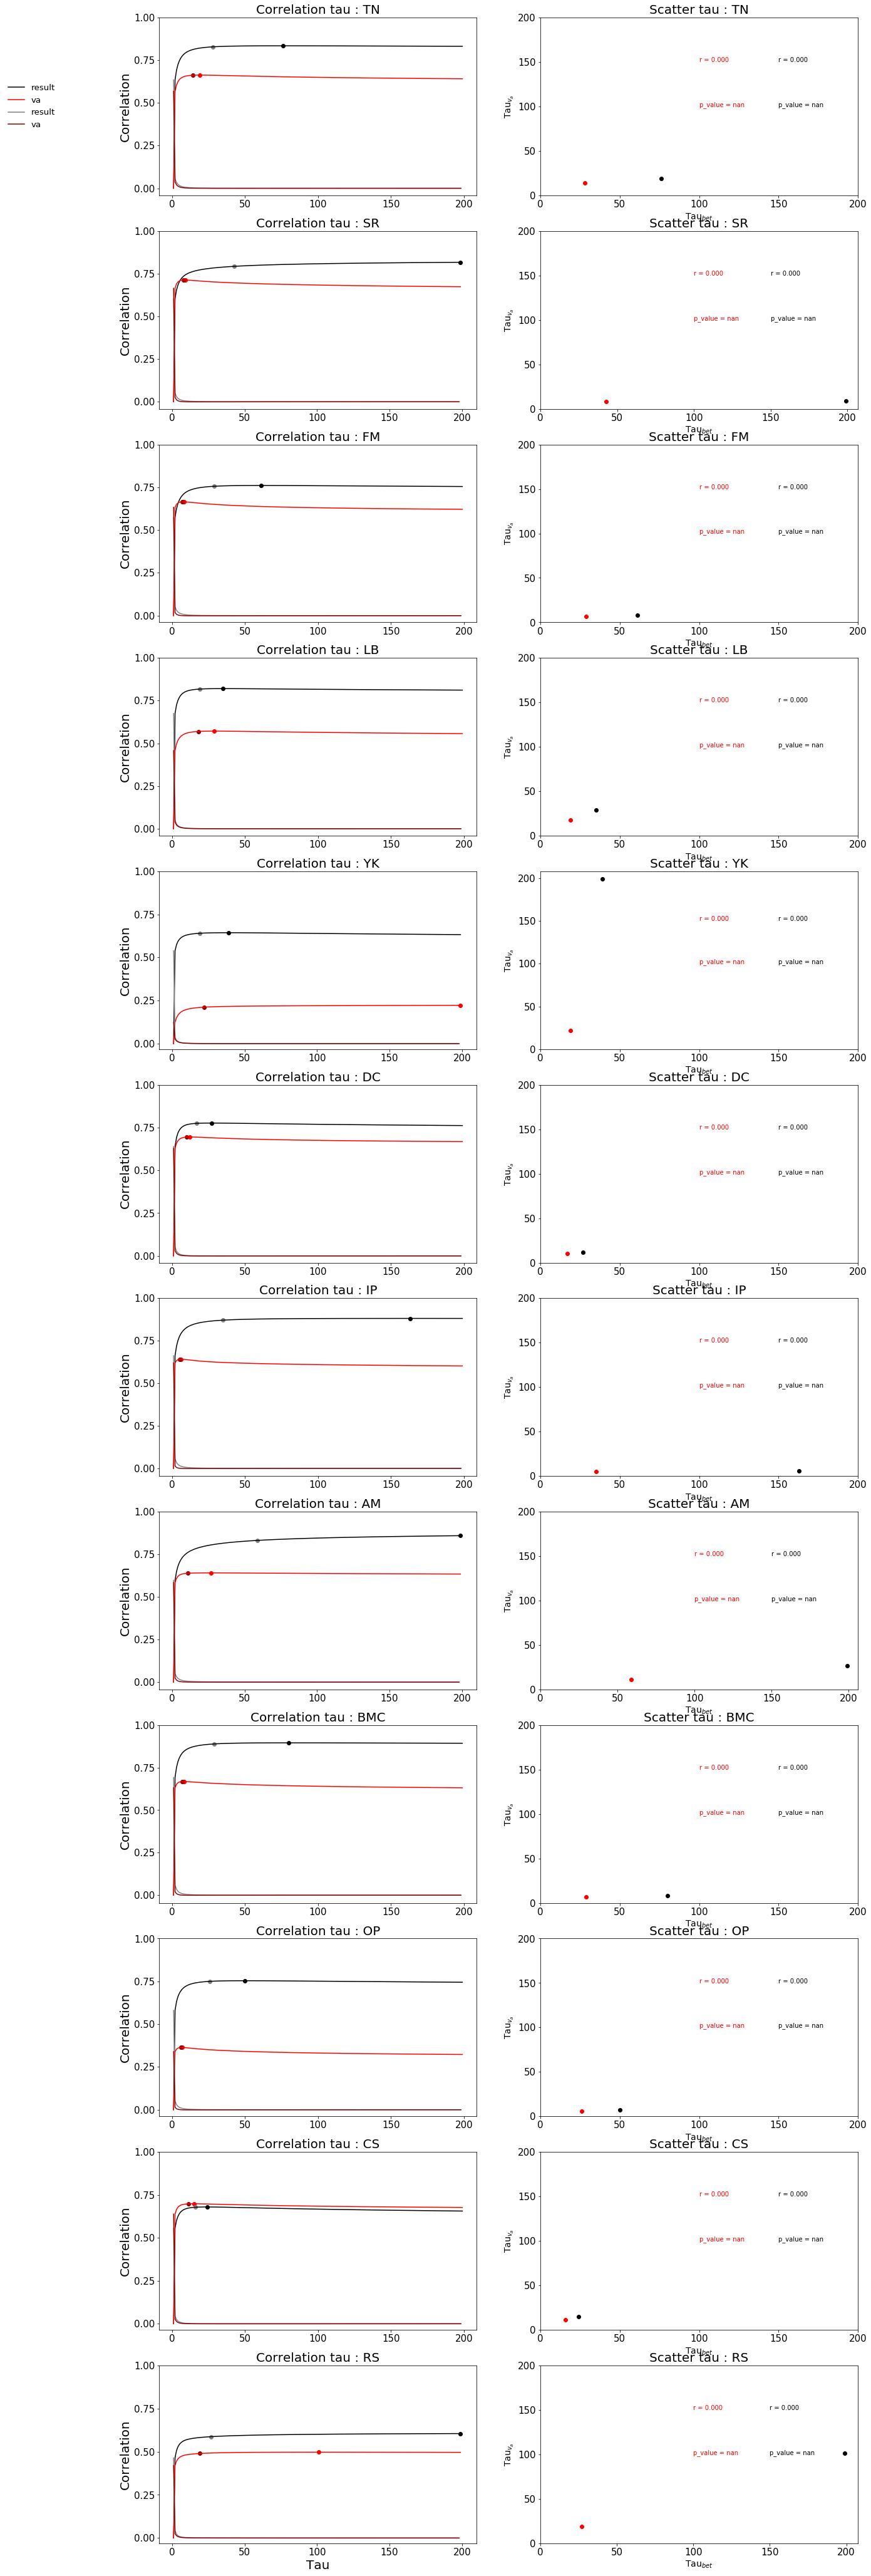

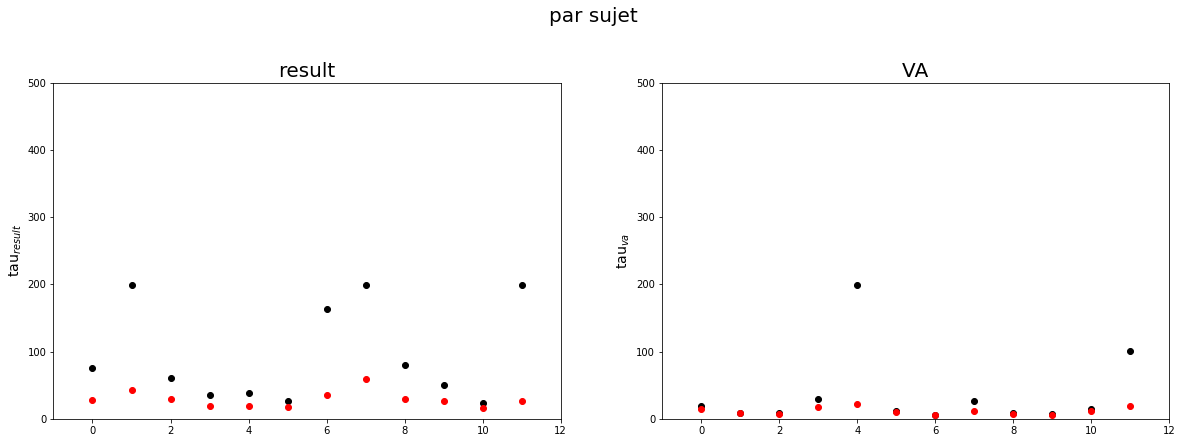

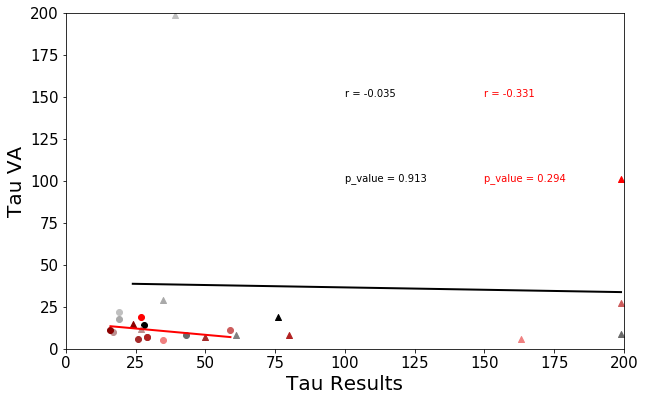

In [12]:
r_full, p_full, r_full_dr, p_full_dr = plot_corr_tau(plot='sujet')
plot_par_sujet(plot='sujet')
plot_va_vs_bet(plot='sujet', mean=None)

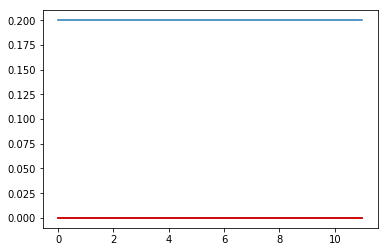

In [13]:
plt.plot(r_full, 'k')
plt.plot(r_full_dr, 'r')

plt.plot(p_full, '--k')
plt.plot(p_full_dr, '--r')

plt.plot(np.ones(len(r_full))*0.2)

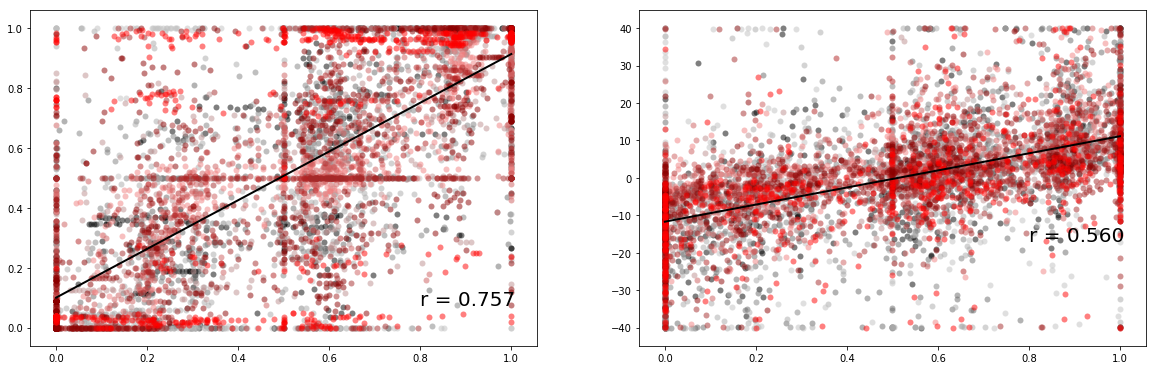

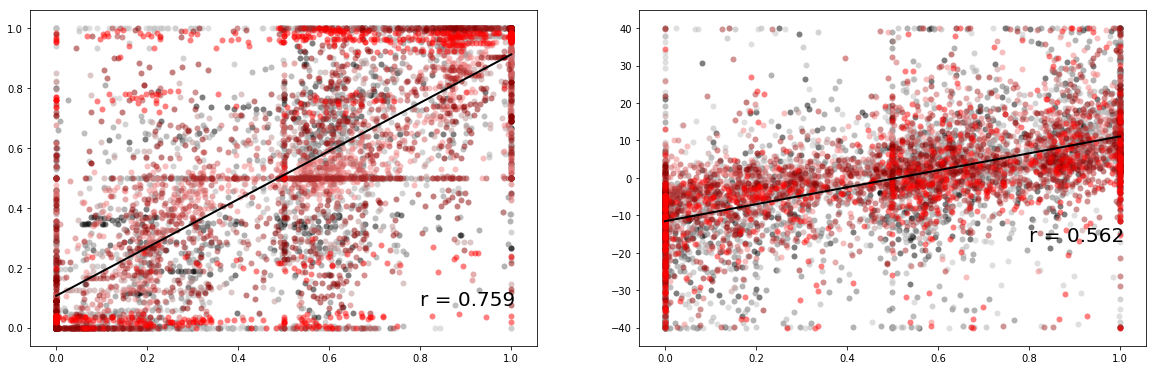

In [14]:
scatter_plot(plot='sujet')
scatter_plot(plot='sujet', dr='yes')

# Test avec les blocs

/usr/local/lib/python3.5/dist-packages/scipy/stats/_stats_mstats_common.py:107: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/usr/local/lib/python3.5/dist-packages/scipy/stats/_stats_mstats_common.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


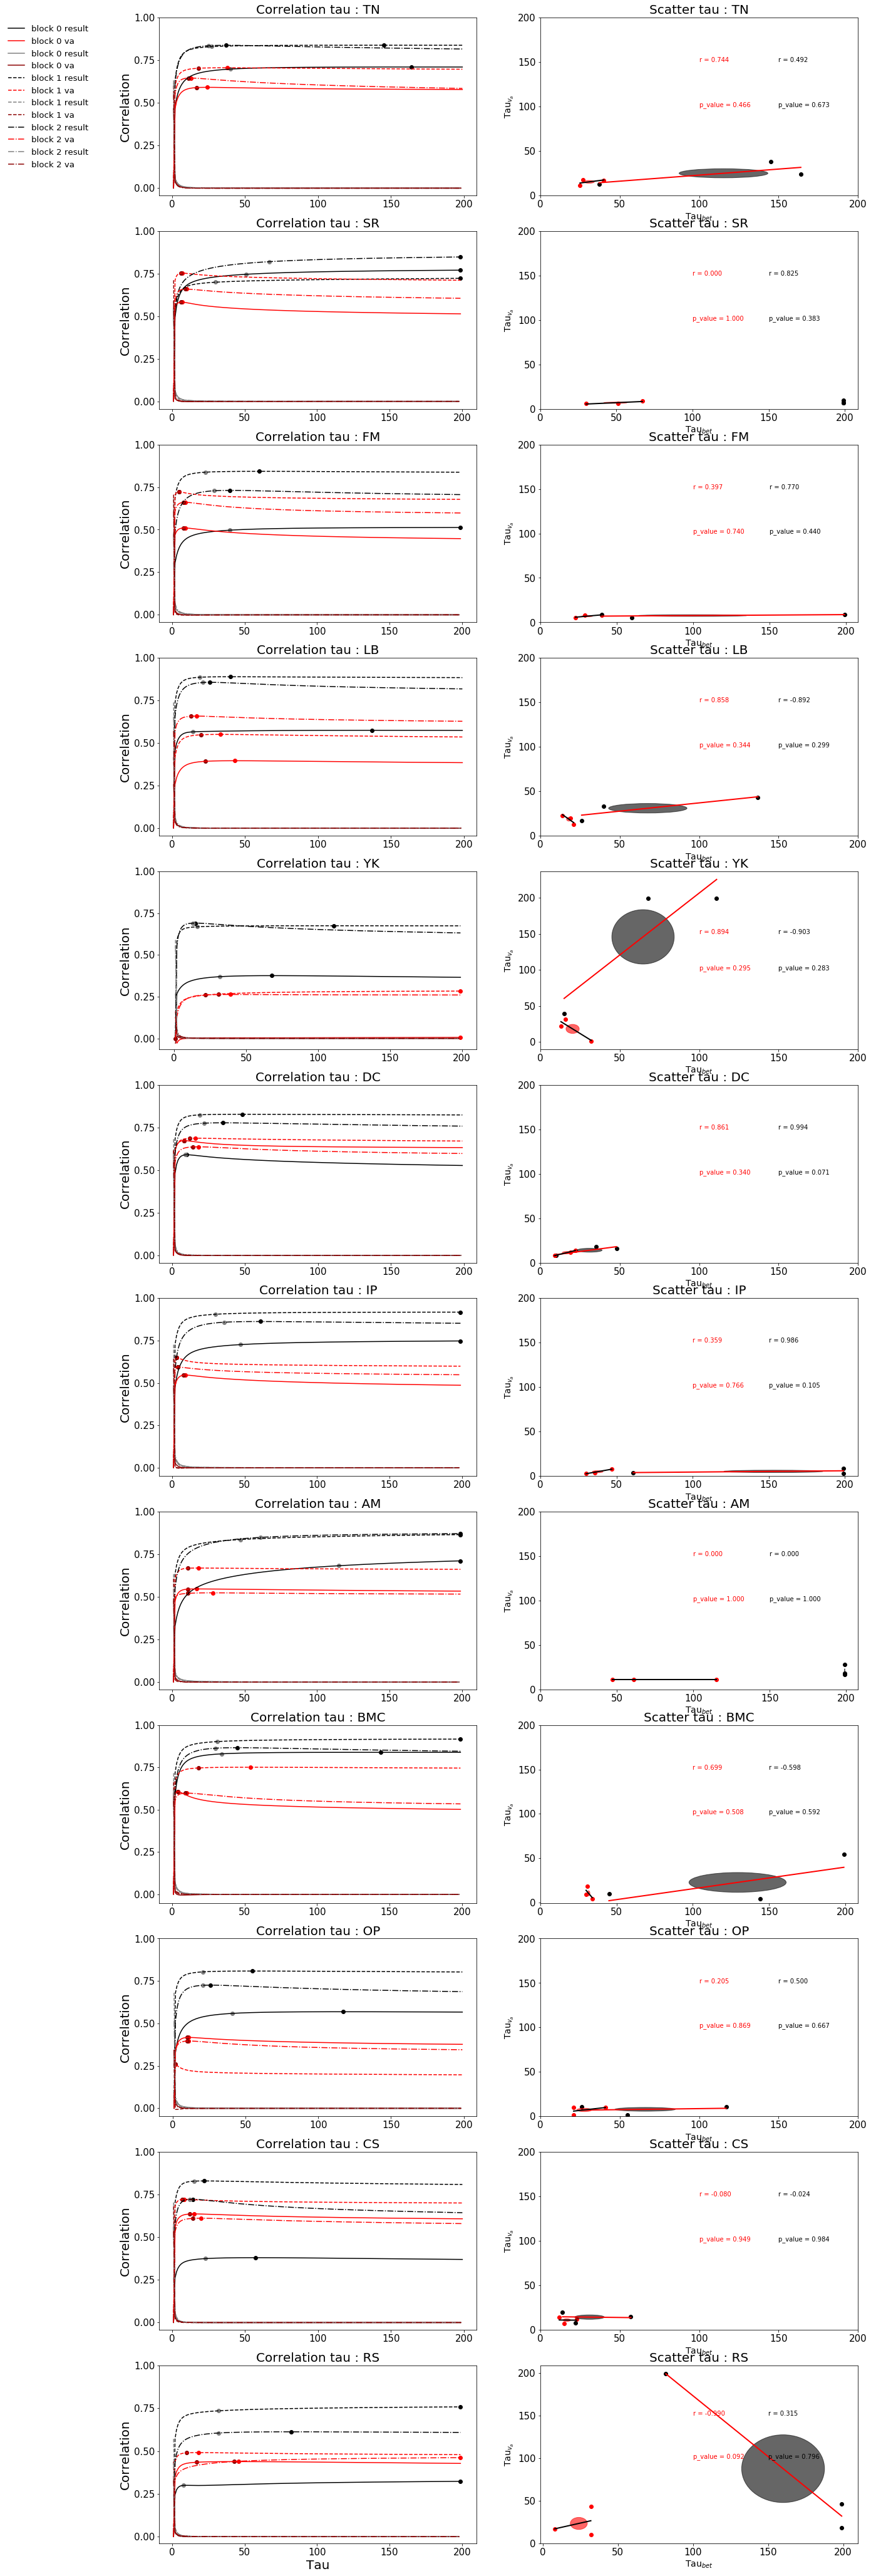

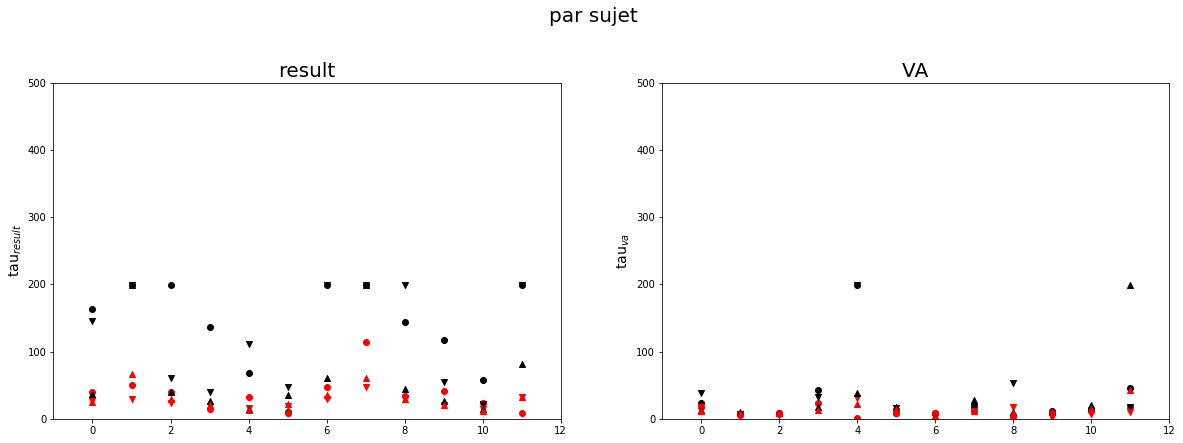

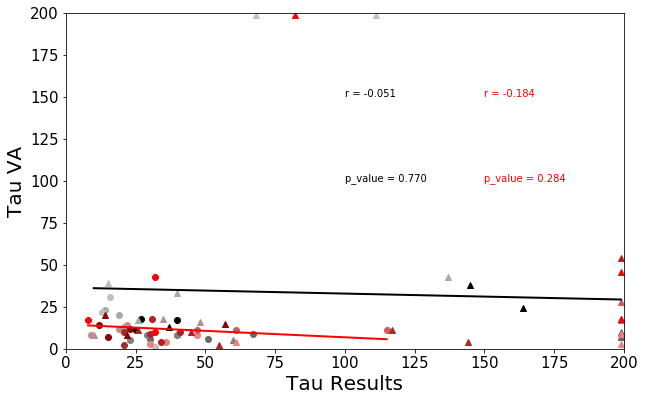

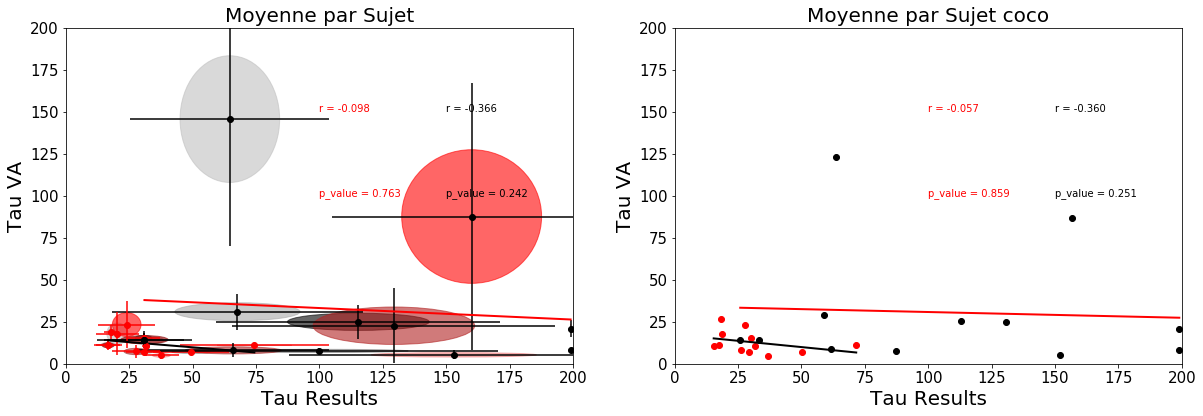

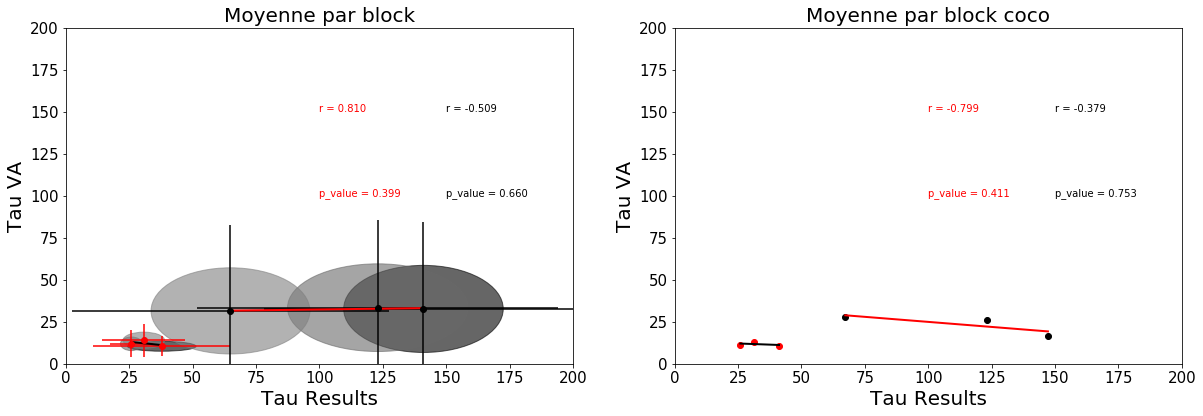

In [15]:
r_full, p_full, r_full_dr, p_full_dr = plot_corr_tau(plot='block')
plot_par_sujet(plot='block')
plot_va_vs_bet(plot='block', mean=None)
plot_va_vs_bet(plot='block', mean='sujet')
plot_va_vs_bet(plot='block', mean='block')


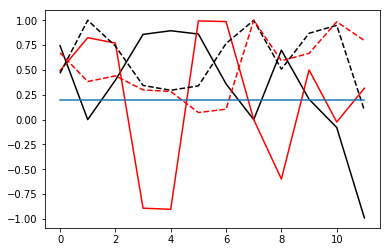

In [16]:
plt.plot(r_full, 'k')
plt.plot(r_full_dr, 'r')

plt.plot(p_full, '--k')
plt.plot(p_full_dr, '--r')

plt.plot(np.ones(len(r_full))*0.2)

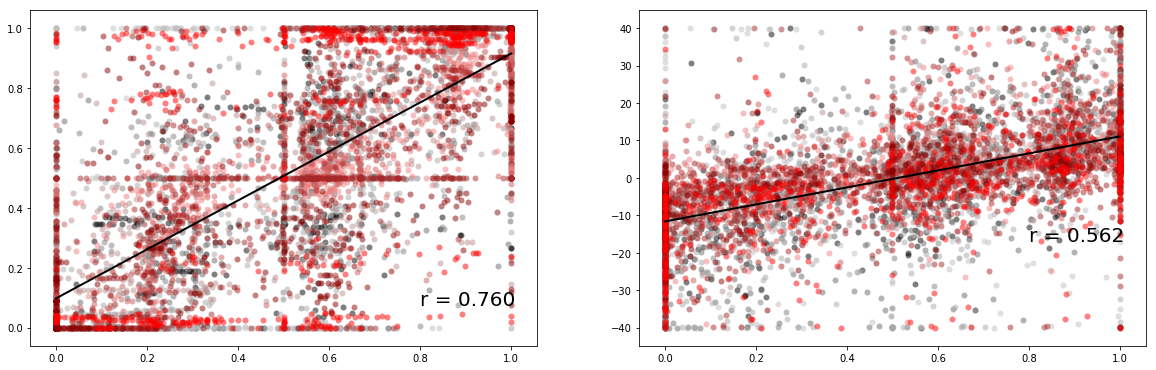

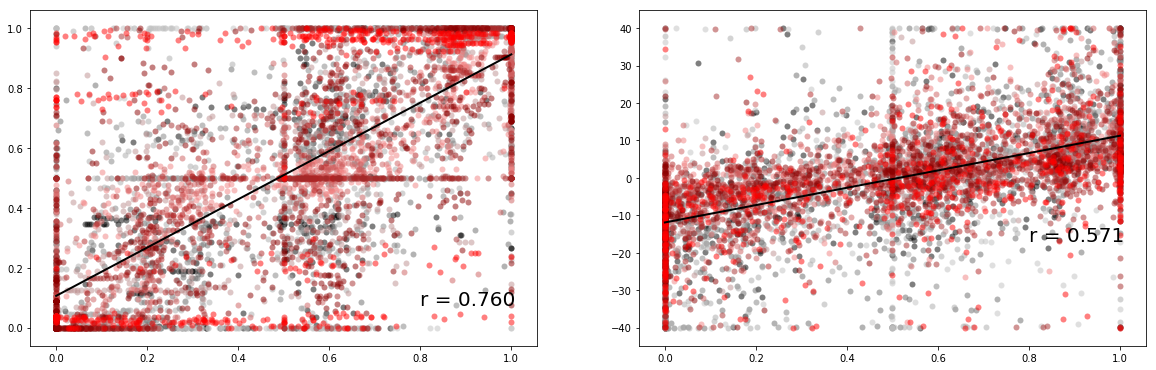

In [17]:
scatter_plot(plot='block')
scatter_plot(plot='block', dr='yes')

# pour chaque pause

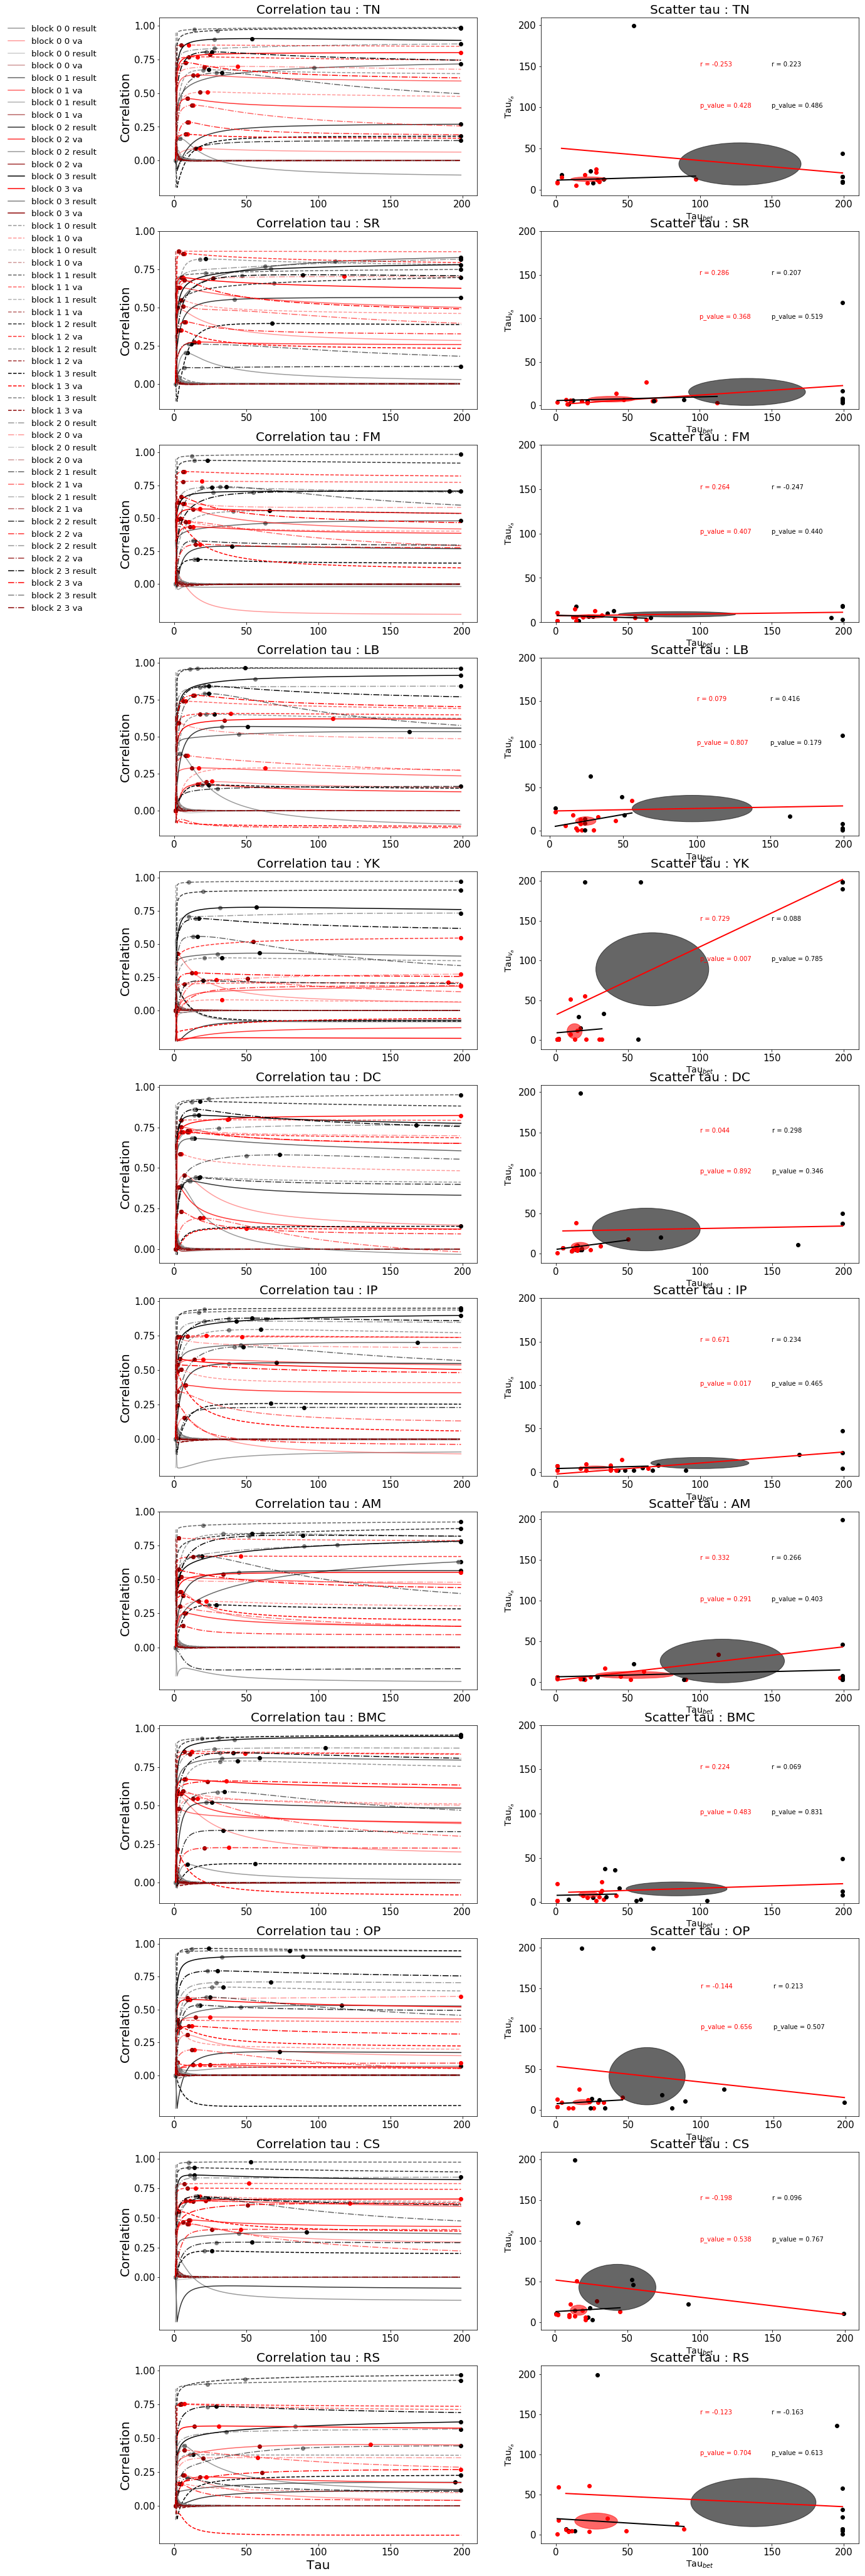

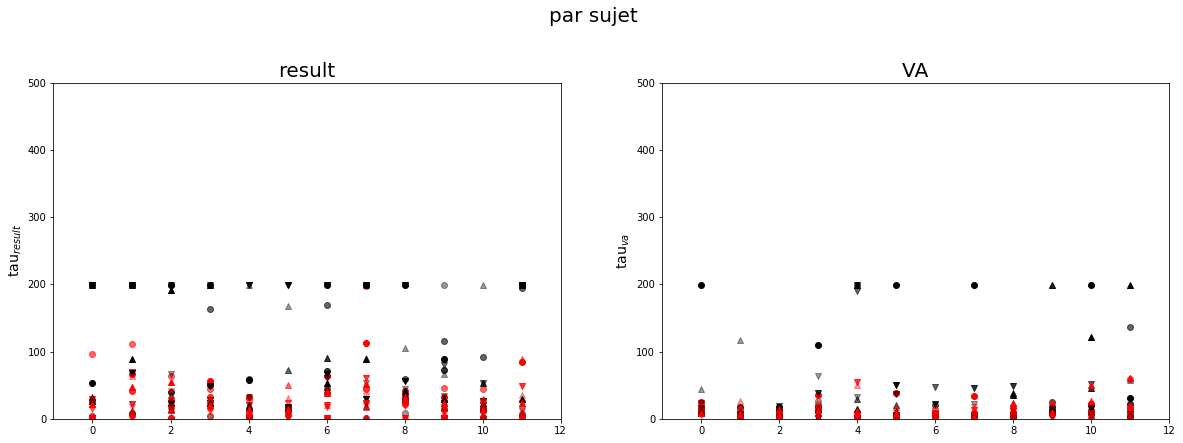

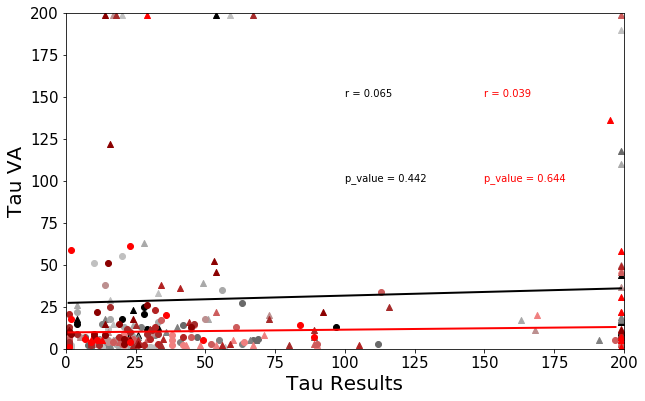

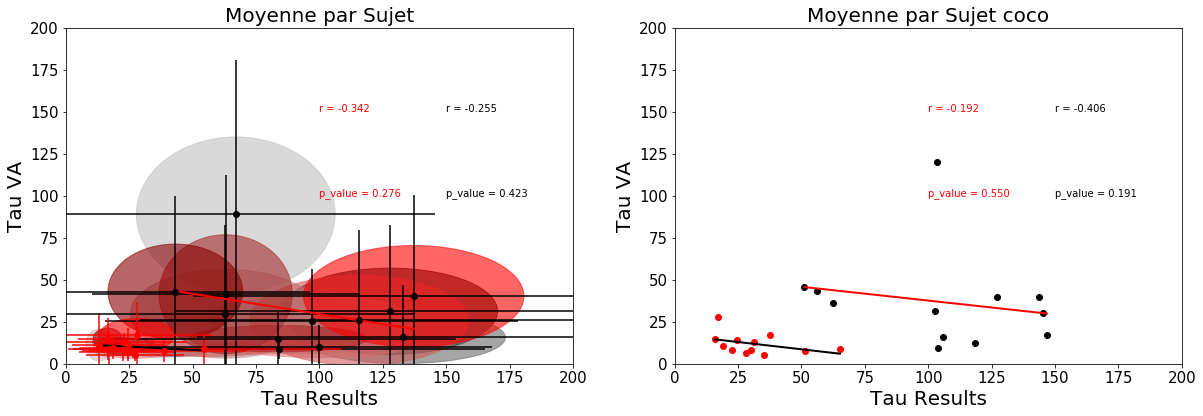

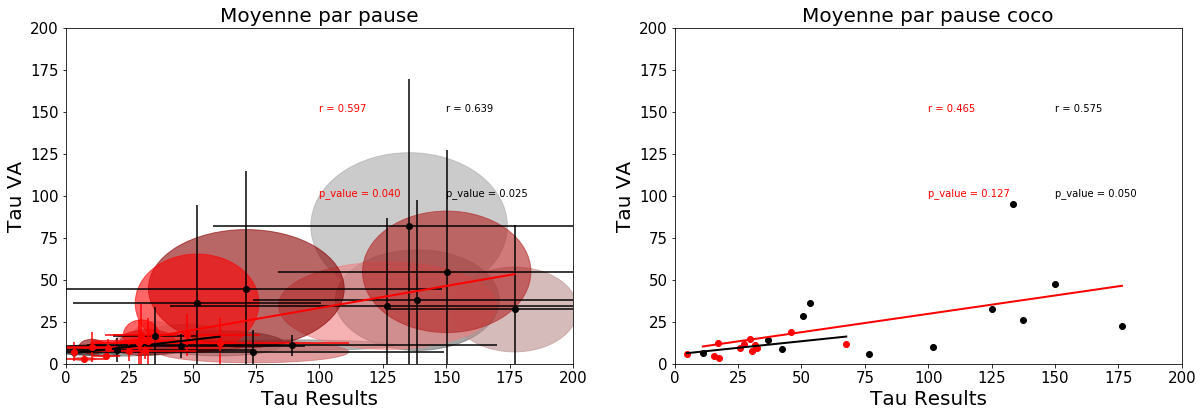

In [18]:
r_full, p_full, r_full_dr, p_full_dr = plot_corr_tau(plot='pause')
plot_par_sujet(plot='pause')
plot_va_vs_bet(plot='pause', mean=None)
plot_va_vs_bet(plot='pause', mean='sujet')
plot_va_vs_bet(plot='pause', mean='block')

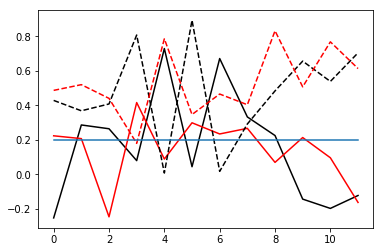

In [19]:
plt.plot(r_full, 'k')
plt.plot(r_full_dr, 'r')

plt.plot(p_full, '--k')
plt.plot(p_full_dr, '--r')

plt.plot(np.ones(len(r_full))*0.2)

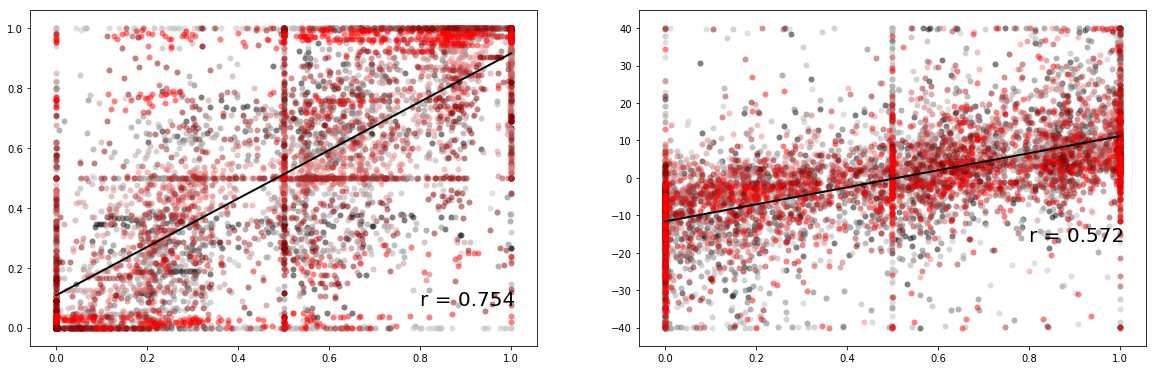

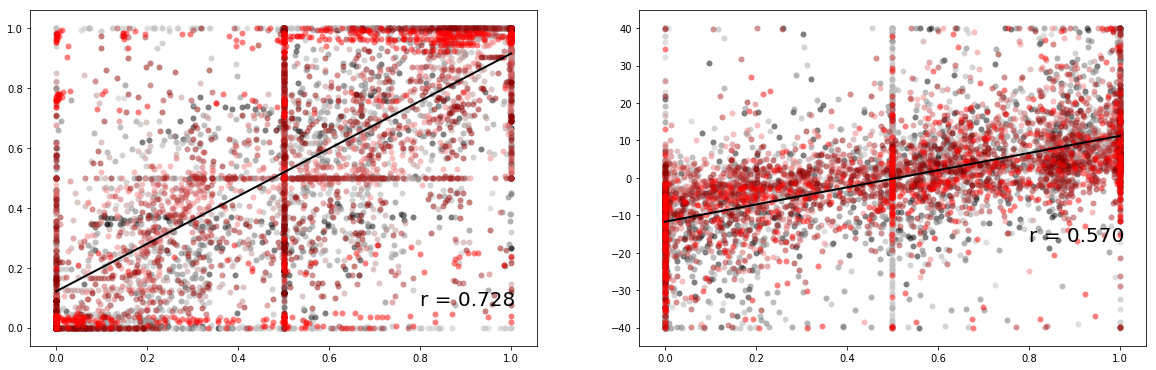

In [20]:
scatter_plot(plot='pause')
scatter_plot(plot='pause', dr='yes')

# Juste Elipse

In [21]:
def plot_elipse(plot='full') :
    if plot=='full' :
        fig, axs = plt.subplots(1, 2, figsize=(2*fig_width, 1*fig_width/(1.6180)))
    else :
        fig, axs = plt.subplots(len(exp), 2, figsize=(2*(fig_width), len(exp)*(fig_width)/(1.6180)))
    
    colors = ['black','dimgrey','grey','darkgrey','silver','rosybrown','lightcoral','indianred','firebrick','brown','darkred','red']
    marker = ['o', 'v', '^'] 
    alpha = [0.4, 0.6,0.8,1]
    mean_tau_r, mean_tau_v, average_tau_r, average_tau_v = [], [], [], []
    mean_tau_r_dr, mean_tau_v_dr, average_tau_r_dr, average_tau_v_dr = [], [], [], []
    
    for x in range(len(exp)) :
        
        tau_r, coco_r, tau_v, coco_v = [], [], [], []
        tau_r_dr, coco_r_dr, tau_v_dr, coco_v_dr = [], [], [], []
        s = exp[x]['observer'] # sujet
        baba = 0
        for block in range(N_blocks) :
            liste = [0,50,100,150,200]
            for a in range(len(liste)-1) :

                full_liste_tau = [liste_tau_pause[s][block][a]['result'][0], liste_tau_pause[s][block][a]['va'][0],
                                  liste_tau_pause[s][block][a]['result'][1], liste_tau_pause[s][block][a]['va'][1]]

                full_liste_tau_dr = [liste_tau_dr_pause[s][block][a]['result'][0], liste_tau_dr_pause[s][block][a]['va'][0],
                                     liste_tau_dr_pause[s][block][a]['result'][1], liste_tau_dr_pause[s][block][a]['va'][1]]

                for b, l in enumerate([tau_r, tau_v, coco_r, coco_v]) :
                    l.append(full_liste_tau[b])
                for b, l in enumerate([tau_r_dr, tau_v_dr, coco_r_dr, coco_v_dr]) :
                    l.append(full_liste_tau_dr[b])
        
        if plot=='full' :
            ax0=axs[0]
            ax1=axs[1]
        else :
            ax0=axs[x][0]
            ax1=axs[x][1]
        
        ells = Ellipse((np.mean(tau_r), np.mean(tau_v)), np.std(tau_r), np.std(tau_v), 0)
        ells.set_clip_box(ax0.bbox)
        ells.set_alpha(0.6)
        ells.set_color(colors[x])
        ax0.add_artist(ells)
        mean_tau_r.append(np.mean(tau_r))
        mean_tau_v.append(np.mean(tau_v))
        
        ells = Ellipse((np.mean(tau_r_dr), np.mean(tau_v_dr)), np.std(tau_r_dr), np.std(tau_v_dr), 0)
        ells.set_clip_box(ax1.bbox)
        ells.set_alpha(0.6)
        ells.set_color(colors[x])
        ax1.add_artist(ells)
        mean_tau_r_dr.append(np.mean(tau_r_dr))
        mean_tau_v_dr.append(np.mean(tau_v_dr))
        
        if plot!='full' :
            l_regress(axs[x][0], tau_r, tau_v, c='k', position=1)
            l_regress(axs[x][1], tau_r_dr, tau_v_dr, c='k', position=1, p_y=100)
            
            
            for a in range(2) :
                axs[x][a].set_xlabel('Tau Results', fontsize=t_label/2)
                axs[x][a].set_ylabel('Tau VA', fontsize=t_label/2)
                axs[x][a].tick_params(direction='out', right=False, top=False,  labelsize=5)
            axs[x][0].axis([0,tau_max,0,tau_max])
            axs[x][1].axis([0,100,0,100])

            axs[x][0].set_title('%s'%s, fontsize=15)
            axs[x][1].set_title('%s dr'%s, fontsize=15)
    
    if plot=='full' :
        l_regress(axs[0], mean_tau_r, mean_tau_v, c='k', position=1)
        l_regress(axs[1], mean_tau_r_dr, mean_tau_v_dr, c='k', position=1, p_y=100)

        for a in range(2) :
            axs[a].set_xlabel('Tau Results', fontsize=t_label)
            axs[a].set_ylabel('Tau VA', fontsize=t_label)
            axs[a].tick_params(direction='out', right=False, top=False,  labelsize=15)
        axs[0].axis([0,tau_max,0,tau_max])
        axs[1].axis([0,100,0,100])

        axs[0].set_title('Moyenne par Sujet', fontsize=20)
        axs[1].set_title('Moyenne par Sujet dr', fontsize=20)

    plt.show()

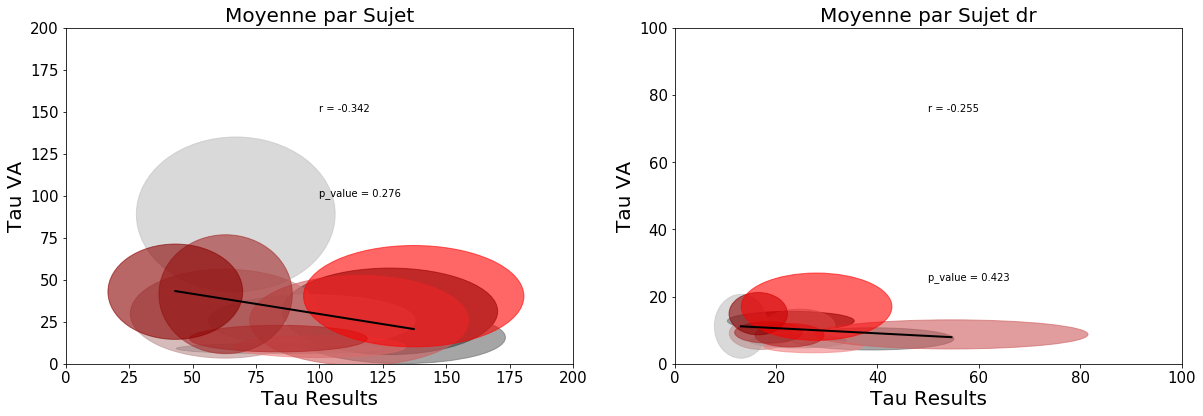

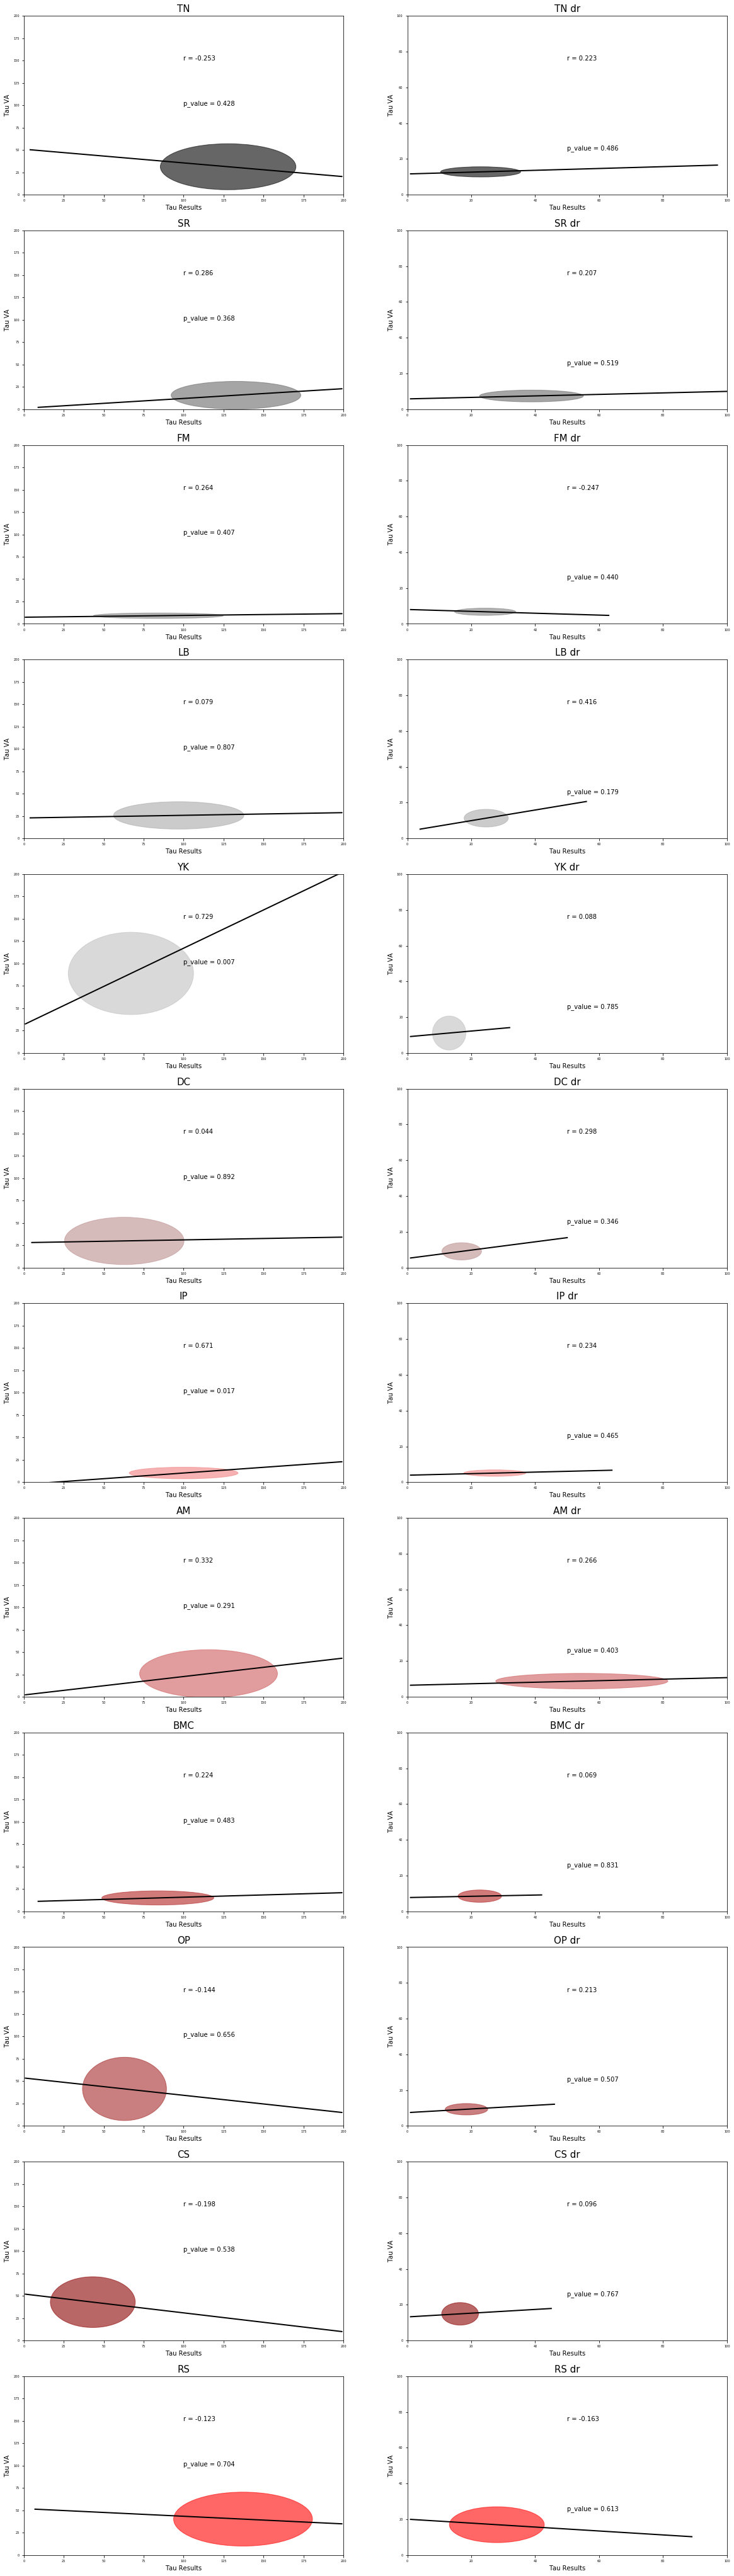

In [22]:
plot_elipse(plot='full')
plot_elipse(plot='sujet')